## Import dependencies

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time
from collections import OrderedDict

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    # tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    if isinstance(sidelen, int):  # If sidelen is a single integer
        tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    elif isinstance(sidelen, tuple):  # If sidelen is a tuple of dimensions
        tensors = [torch.linspace(-1, 1, steps=s) for s in sidelen]
    else:
        raise TypeError("sidelen must be an int or tuple of ints.")
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [2]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

## Load the image

In [3]:
def get_tensor(image, sidelength):
    # img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(image)
    return img


Fitting image

In [4]:
class ImageFitting(Dataset):
    def __init__(self, image, sidelength):
        super().__init__()

        if isinstance(sidelength, int):
            self.coords = get_mgrid(sidelength, dim=2)
        elif isinstance(sidelength, tuple):
            self.coords = get_mgrid(sidelength, dim=len(sidelength))
        else:
            raise ValueError("sidelength must be an int or tuple of ints.")

        img = get_tensor(image, sidelength)

        # self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.pixels = img.permute(1, 2, 0).reshape(-1, 1)
        # Prepare pixels (flattened RGB values)
        # self.pixels = img.permute(1, 2, 0).contiguous().view(-1, img.size(0))  # RGB = 3 channels

        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

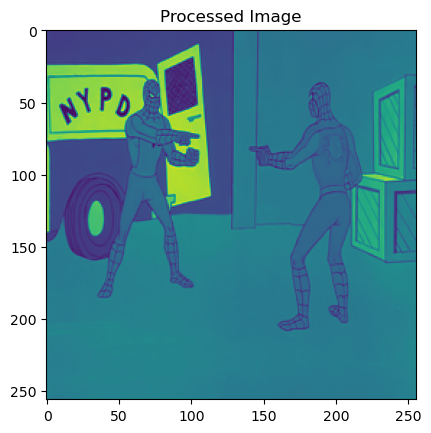

/opt/homebrew/Caskroom/miniforge/base/envs/DP/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1730862381898/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# image = Image.open('heyayayaya.jpg')
image = Image.open('spiderman.jpg')

# Convert the image to grey scale or the dimension of the image would be too big to train
image = image.convert("L")

# Define the dimension of the image
imgx = 256
imgy = 256

image = image.resize((imgx, imgy))
plt.imshow(image)
plt.title("Processed Image")
plt.show()



heyayaya = ImageFitting(image, (imgx, imgy))
dataloader = DataLoader(heyayaya, batch_size=64, pin_memory=True, num_workers=0)

# Design my Activation Function (periodic function)

Import my own activation function and model

In [6]:
# from CREN import Cren
# from CustomAct import custom_activation
# Define the custom activation function
def custom_activation(x):
    f = 2 * torch.cos(x)  # f(x) = 2cos(x)
    g = torch.cos(2.5 * x + 2)  # g(x) = cos(2.5x + 2)
    return f + g  # h(x) = f(x) + g(x)


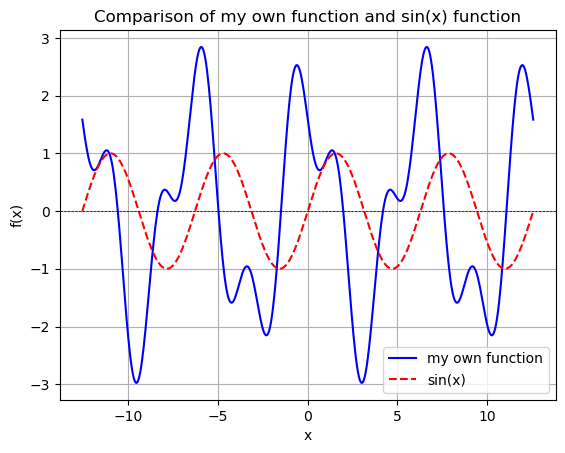

In [7]:
# Generate input data
x = torch.linspace(-4 * np.pi, 4 * np.pi, 500)  # Input range from 0 to 4π

# Compute the triangle wave
y_custom = custom_activation(x)


# Compute the sine wave for comparison
y_sine = torch.sin(x)

custom_name = 'my own function'

# Plot both waves
plt.plot(x.numpy(), y_custom.numpy(), label=f"{custom_name}", color="blue")
plt.plot(x.numpy(), y_sine.numpy(), label="sin(x)", linestyle="--", color="red")
plt.title(f"Comparison of {custom_name} and sin(x) function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend(loc='lower right')
plt.grid()
plt.show()




In [8]:
import torch
from torch import nn
from torch.utils.data import  Dataset
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
from collections import OrderedDict

class CustomLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        # return triangle_wave(self.omega_0 * self.linear(input))
        return custom_activation(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        # return triangle_wave(intermediate), intermediate
        return custom_activation(intermediate), intermediate


class Cren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(CustomLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(CustomLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(CustomLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, CustomLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [9]:
from SIREN import Siren

img_cren = Cren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
# img_sqren = img_sqren.cuda()

Training loop for my model

In [10]:
# Define parameters for training loop
total_steps = 200 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

Step 0, My model's total loss 0.149245
Step 0, SIREN's total loss 0.123167


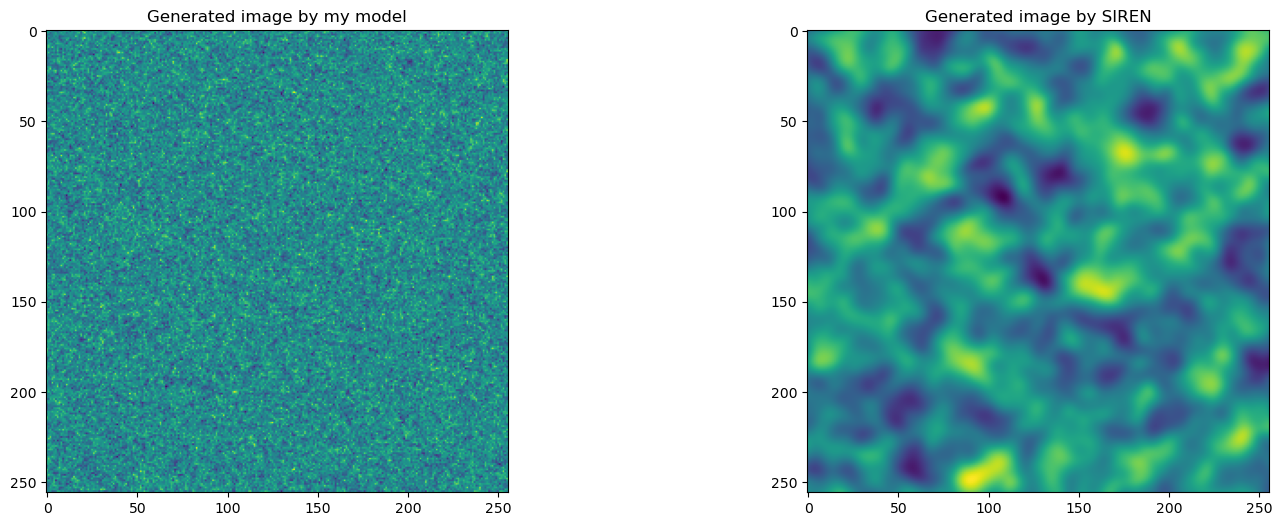

Step 50, My model's total loss 0.000266
Step 50, SIREN's total loss 0.013572


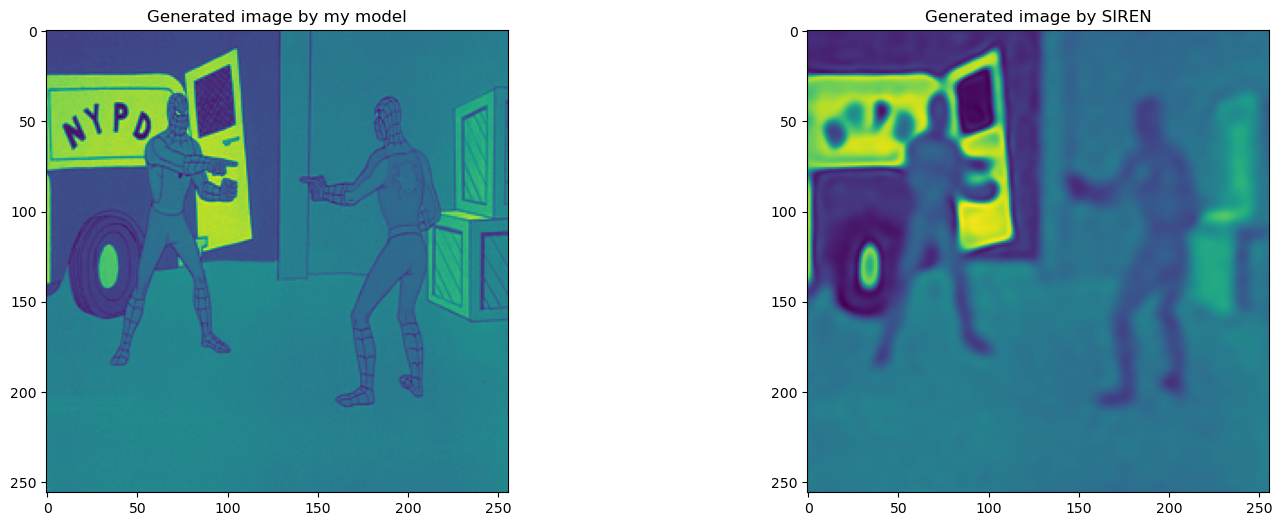

Step 100, My model's total loss 0.000002
Step 100, SIREN's total loss 0.008159


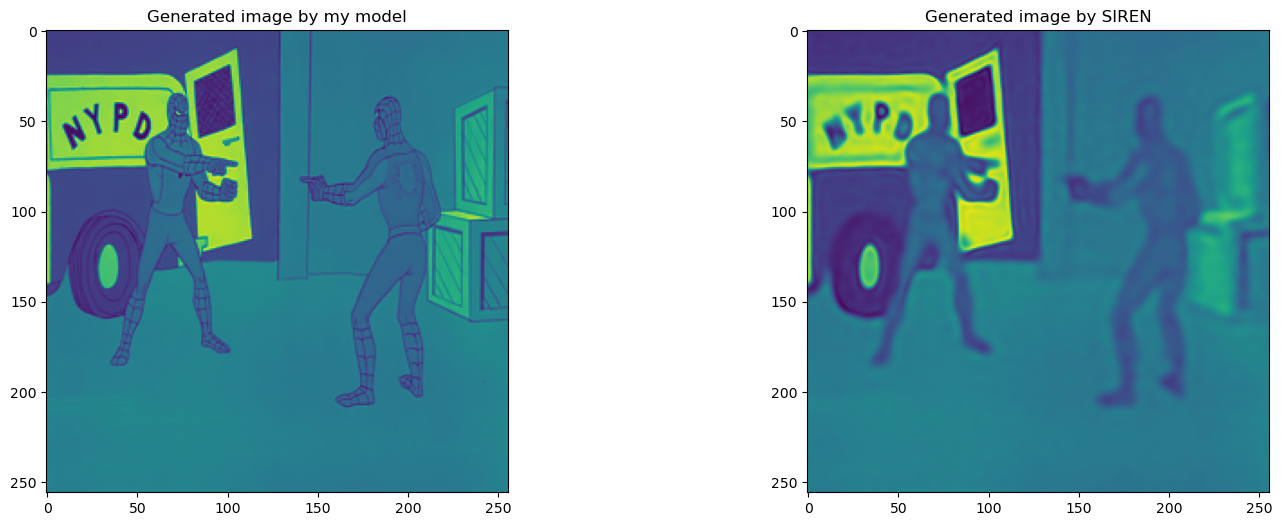

Step 150, My model's total loss 0.000000
Step 150, SIREN's total loss 0.005392


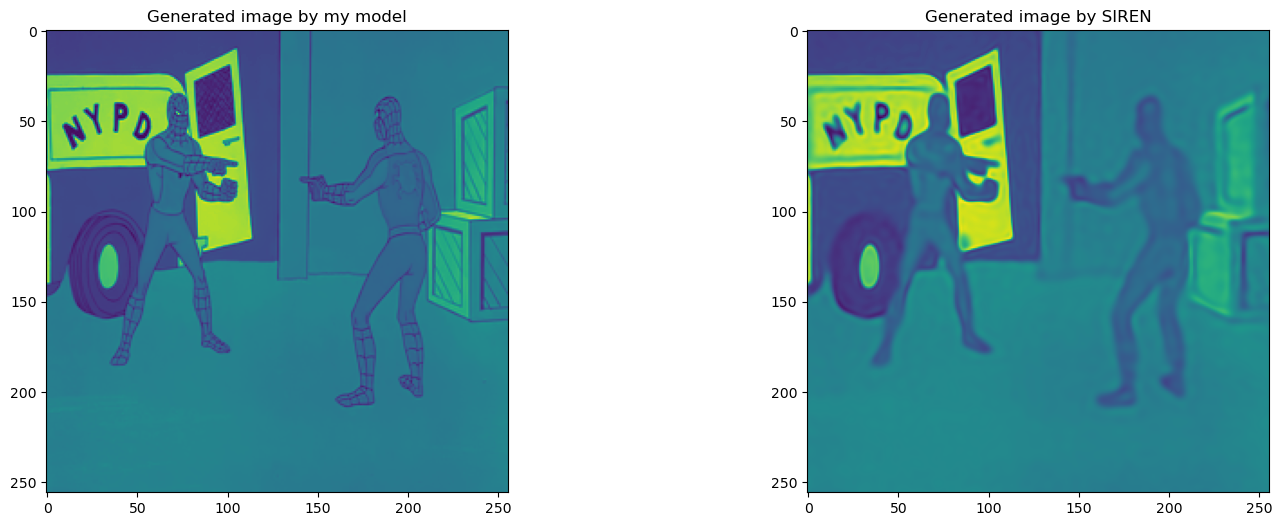

Step 200, My model's total loss 0.000000
Step 200, SIREN's total loss 0.003419


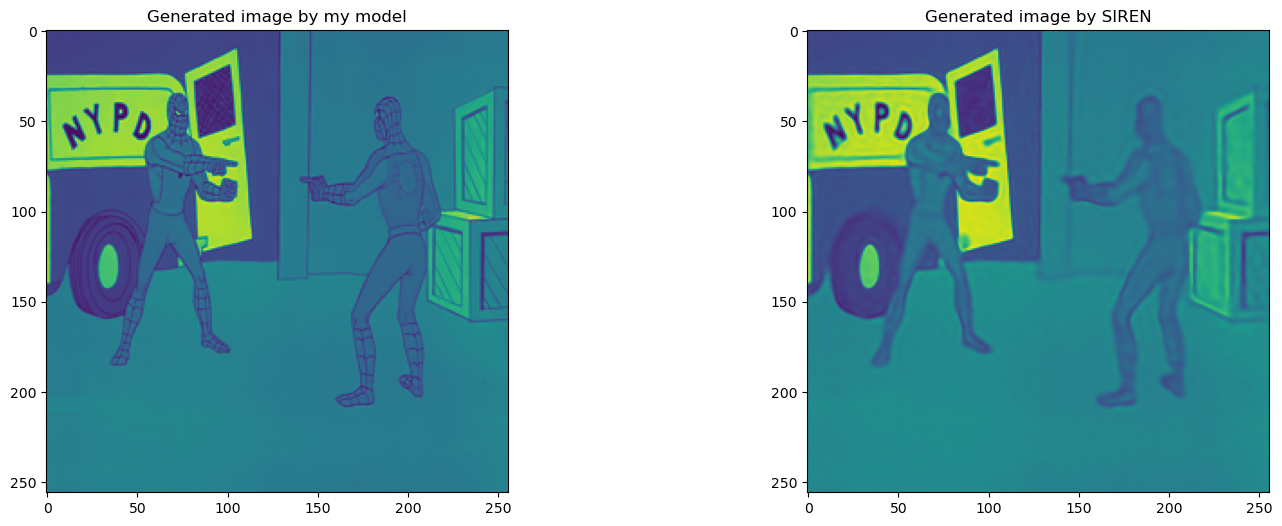

In [11]:
optim_c = torch.optim.Adam(lr=1e-4, params=img_cren.parameters())
optim_s = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
# model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

training_loss_c = []
training_loss_s = []

for step in range(total_steps+1):
    # CREN's model and loss function
    model_output_c, coords_c = img_cren(model_input)
    loss_c = ((model_output_c - ground_truth)**2).mean()

    # SIREN's model and loss function
    model_output_s, coods_s = img_siren(model_input)
    loss_s = ((model_output_s - ground_truth)**2).mean()


    if not step % steps_til_summary:
        print("Step %d, My model's total loss %0.6f" % (step, loss_c))
        print("Step %d, SIREN's total loss %0.6f" % (step, loss_s))


        fig, axes = plt.subplots(1,2, figsize=(18,6))
        axes[0].imshow(model_output_c.cpu().view(imgx,imgy).detach().numpy())
        axes[0].set_title("Generated image by my model")
        axes[1].imshow(model_output_s.cpu().view(imgx,imgy).detach().numpy())
        axes[1].set_title("Generated image by SIREN")
        plt.show()
        # plt.savefig(f"{step}th_generated_plot.png")
        # plt.close(fig)  # Close figure to save memory


    # Backpropagation and Loss caculation for CREN
    optim_c.zero_grad()
    loss_c.backward()
    optim_c.step()

    training_loss_c.append(loss_c.item())

    # Backpropagation and Loss caculation for SIREN
    optim_s.zero_grad()
    loss_s.backward()
    optim_s.step()

    training_loss_s.append(loss_s.item())

    torch.cuda.empty_cache()

Training loss for my model

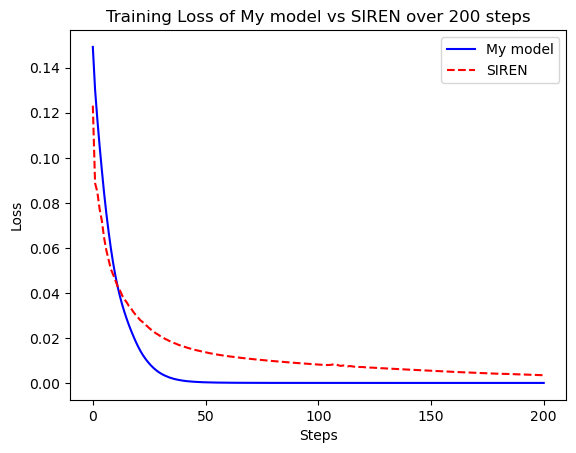

In [13]:
plt.plot(training_loss_c, label="My model", color='blue')
plt.plot(training_loss_s, label='SIREN', color='red', linestyle='--')
plt.title(f"Training Loss of My model vs SIREN over {total_steps} steps")
plt.xticks(range(0, total_steps+1, steps_til_summary))
plt.xlabel("Steps", )
plt.ylabel("Loss")
plt.legend()
plt.show()